In [1]:
# Tensorflow 2.3でメモリを指定及び節約して使うためのおまじない。
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[4], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[4], True)

import numpy as np
import random

np.random.seed(219)
random.seed(219)
tf.random.set_seed(219)

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
import imageio

class DataLoader():
    def __init__(self, img_res=(128, 128)):
        self.img_res = img_res

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob(f'/workdir/taki_lab/cycle_gan/apple2orange/{data_type}A/*')
        path_B = glob(f'/workdir/taki_lab/cycle_gan/apple2orange/{data_type}B/*')

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = np.array(Image.open(img_A))
                img_B = np.array(Image.open(img_B))
                
                img_A = np.array(Image.fromarray(img_A).resize(self.img_res))
                img_B = np.array(Image.fromarray(img_B).resize(self.img_res))

                if not is_testing and np.random.random() > 0.5:
                    img_A = np.fliplr(img_A)
                    img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

In [3]:
IMAGE_SIZE = 128
data_loader = DataLoader(img_res=(IMAGE_SIZE, IMAGE_SIZE))

In [4]:
import tensorflow as tf
import keras

from tensorflow.keras.layers import Layer, InputSpec
import keras.backend as K

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [5]:
import scipy

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, add

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from tensorflow.keras.utils import plot_model

import sys

import numpy as np
import os
import random

from collections import deque

In [6]:
class CycleGAN():
    def __init__(self, input_dim, learning_rate, lambda_validation, lambda_reconstr,
                 lambda_id, generator_type, gen_n_filters, disc_n_filters, buffer_max_length = 50):

        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.buffer_max_length = buffer_max_length
        self.lambda_validation = lambda_validation
        self.lambda_reconstr = lambda_reconstr
        self.lambda_id = lambda_id
        self.generator_type = generator_type
        self.gen_n_filters = gen_n_filters
        self.disc_n_filters = disc_n_filters

        # Input shape
        self.img_rows = input_dim[0]
        self.img_cols = input_dim[1]
        self.channels = input_dim[2]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self.buffer_A = deque(maxlen = self.buffer_max_length)
        self.buffer_B = deque(maxlen = self.buffer_max_length)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**3)
        self.disc_patch = (patch, patch, 1)
        
        # 各重みの初期値をHeの初期値に
        self.weight_init = RandomNormal(mean=0., stddev=0.02)
        self.compile_models()

        
    def compile_models(self):

        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        
        self.d_A.compile(loss='mse',
            optimizer=Adam(self.learning_rate, 0.5),
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=Adam(self.learning_rate, 0.5),
            metrics=['accuracy'])

        if self.generator_type == 'unet':
            self.g_AB = self.build_generator_unet()
            self.g_BA = self.build_generator_unet()
        else:
            self.g_AB = self.build_generator_resnet()
            self.g_BA = self.build_generator_resnet()

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.lambda_validation, self.lambda_validation,
                                            self.lambda_reconstr, self.lambda_reconstr,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=Adam(0.0002, 0.5))

        self.d_A.trainable = True
        self.d_B.trainable = True
    

    def build_generator_unet(self):

        def downsample(layer_input, filters, f_size=4):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = InstanceNormalization(axis = -1, center = False, scale = False)(d)
            d = Activation('relu')(d)
            
            return d

        def upsample(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
            u = InstanceNormalization(axis = -1, center = False, scale = False)(u)
            u = Activation('relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)

            u = Concatenate()([u, skip_input])
            return u

        # Image input
        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = downsample(img, self.gen_n_filters) 
        d2 = downsample(d1, self.gen_n_filters*2)
        d3 = downsample(d2, self.gen_n_filters*4)
        d4 = downsample(d3, self.gen_n_filters*8)

        # Upsampling
        u1 = upsample(d4, d3, self.gen_n_filters*4)
        u2 = upsample(u1, d2, self.gen_n_filters*2)
        u3 = upsample(u2, d1, self.gen_n_filters)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(img, output_img)


    def build_discriminator(self):

        def conv4(layer_input, filters, stride = 2, norm=True):
            y = Conv2D(filters, kernel_size=(4,4), strides=stride, padding='same', kernel_initializer = self.weight_init)(layer_input)
            
            if norm:
                y = InstanceNormalization(axis = -1, center = False, scale = False)(y)

            y = LeakyReLU(0.2)(y)
           
            return y

        img = Input(shape=self.img_shape)

        y = conv4(img, self.disc_n_filters, stride = 2, norm = False)
        y = conv4(y, self.disc_n_filters*2, stride = 2)
        y = conv4(y, self.disc_n_filters*4, stride = 2)
        y = conv4(y, self.disc_n_filters*8, stride = 1)

        output = Conv2D(1, kernel_size=4, strides=1, padding='same',kernel_initializer = self.weight_init)(y)

        return Model(img, output)

    def train_discriminators(self, imgs_A, imgs_B, valid, fake):

        # Translate images to opposite domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        self.buffer_B.append(fake_B)
        self.buffer_A.append(fake_A)

        fake_A_rnd = random.sample(self.buffer_A, min(len(self.buffer_A), len(imgs_A)))
        fake_B_rnd = random.sample(self.buffer_B, min(len(self.buffer_B), len(imgs_B)))

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A_rnd, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B_rnd, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss_total = 0.5 * np.add(dA_loss, dB_loss)

        return (
            d_loss_total[0]
            , dA_loss[0], dA_loss_real[0], dA_loss_fake[0]
            , dB_loss[0], dB_loss_real[0], dB_loss_fake[0]
            , d_loss_total[1]
            , dA_loss[1], dA_loss_real[1], dA_loss_fake[1]
            , dB_loss[1], dB_loss_real[1], dB_loss_fake[1]
        )

    def train_generators(self, imgs_A, imgs_B, valid):

        # Train the generators
        return self.combined.train_on_batch([imgs_A, imgs_B],
                                                [valid, valid,
                                                imgs_A, imgs_B,
                                                imgs_A, imgs_B])


    def train(self, data_loader, epochs, batch_size=1):

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        import wandb
        wandb.init(project="cycle_gan", name="cycle_gan")

        for epoch in range(self.epoch, epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch()):

                d_loss = self.train_discriminators(imgs_A, imgs_B, valid, fake)
                g_loss = self.train_generators(imgs_A, imgs_B, valid)

                wandb.log({
                    "Epochs":self.epoch,
                    "D_loss":d_loss[0],
                    "acc":100*d_loss[7],
                    "G_loss":g_loss[0],
                    "adv":np.sum(g_loss[1:3]),
                    "recon":np.sum(g_loss[3:5]),
                    "id":np.sum(g_loss[5:7])
                })
                
            self.epoch += 1

In [7]:
gan = CycleGAN(
    input_dim = (IMAGE_SIZE,IMAGE_SIZE,3),
    learning_rate = 0.0002,
    buffer_max_length = 50,
    lambda_validation = 1,
    lambda_reconstr = 10,
    lambda_id = 2,
    generator_type = 'unet',
    gen_n_filters = 32,
    disc_n_filters = 32
    )

In [8]:
BATCH_SIZE = 1
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 10

In [ ]:
gan.train(data_loader, EPOCHS)

wandb: Wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [125]:
def sample_image():
    r, c = 2, 4
    path_A = glob(f'/workdir/taki_lab/cycle_gan/apple2orange/testA/*')
    path_B = glob(f'/workdir/taki_lab/cycle_gan/apple2orange/testB/*')

    path_A = np.random.choice(path_A, 1, replace=False)
    path_B = np.random.choice(path_B, 1, replace=False)
        
    img_A = np.array(Image.open(path_A[0]))
    img_B = np.array(Image.open(path_B[0]))

    img_A = np.array(Image.fromarray(img_A).resize((128,128)))
    img_B = np.array(Image.fromarray(img_B).resize((128,128)))

    img_A = np.array(img_A)/127.5 - 1.
    img_B = np.array(img_B)/127.5 - 1.
    
    fake_A = gan.g_BA.predict(np.expand_dims(img_B, 0))
    fake_B = gan.g_AB.predict(np.expand_dims(img_A, 0))
    
    recon_A = gan.g_BA.predict(fake_B)
    recon_B = gan.g_AB.predict(fake_A)
    
    id_A = gan.g_BA.predict(np.expand_dims(img_A, 0))
    id_B = gan.g_AB.predict(np.expand_dims(img_B, 0))
    
    gen_imgs = np.array([img_A, fake_B.squeeze(), recon_A.squeeze(), id_A.squeeze(),
                              img_B, fake_A.squeeze(), recon_B.squeeze(), id_B.squeeze()])
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    gen_imgs = np.clip(gen_imgs, 0, 1)
    
    titles = ['Original', 'Fake', 'Reconstructed', 'ID']
    fig, axs = plt.subplots(r,c, figsize=(25,12.5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i, j].axis("off")
            cnt += 1

    return None

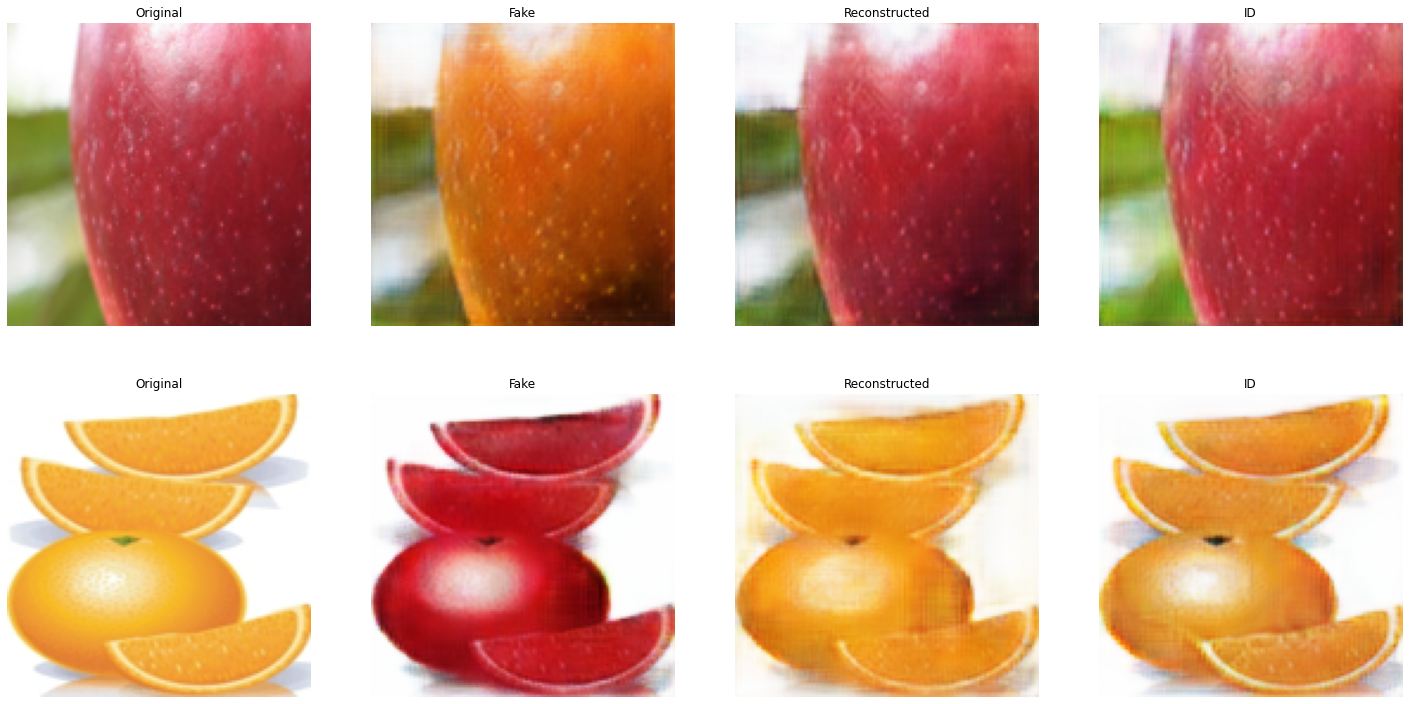

In [136]:
sample_image()